# Repairing Code

_Brief abstract/introduction/motivation.  State what the chapter is about in 1-2 paragraphs._
_Then, have an introduction video:_

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo("w4u5gCgPlmg")

**Prerequisites**

* _Refer to earlier chapters as notebooks here, as here:_ [Earlier Chapter](Fuzzer.ipynb).

In [2]:
import bookutils

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.Repairer import <identifier>
```

and then make use of the following features.


We can repair things!



## Fixing Things Manually

\todo{Add}

In [3]:
from StatisticalDebugger import middle

In [4]:
# ignore
from bookutils import print_content

In [5]:
# ignore
import inspect

In [6]:
# ignore
_, first_lineno = inspect.getsourcelines(middle)
middle_source = inspect.getsource(middle)
print_content(middle_source, '.py', start_line_number=first_lineno)

503  def middle(x, y, z):
504      if y < z:
505          if x < y:
506              return y
507          elif x < z:
508              return y
509      else:
510          if x > y:
511              return y
512          elif x > z:
513              return x
514      return z

## Automatic Code Repair

1. Have a set of tests.
2. Localize the defect.
3. Apply random insert/delete/swap operations.
4. Evolve.

Let's do this on `middle` first.

## A Test Suite

A set of passing tests.

In [7]:
import random

In [8]:
def middle_testcase():
    x = random.randrange(10)
    y = random.randrange(10)
    z = random.randrange(10)
    return x, y, z

In [9]:
[middle_testcase() for i in range(5)]

[(9, 0, 5), (0, 1, 9), (9, 0, 9), (2, 9, 0), (4, 7, 2)]

In [10]:
def middle_test(x, y, z):
    m = middle(x, y, z)
    assert m == sorted([x, y, z])[1]

In [11]:
def middle_passing_testcase():
    while True:
        try:
            x, y, z = middle_testcase()
            _ = middle_test(x, y, z)
            return x, y, z
        except AssertionError:
            pass

In [12]:
(x, y, z) = middle_passing_testcase()
m = middle(x, y, z)
print(f"middle({x}, {y}, {z}) = {m}")

middle(1, 6, 1) = 1


In [13]:
def middle_failing_testcase():
    while True:
        try:
            x, y, z = middle_testcase()
            _ = middle_test(x, y, z)
        except AssertionError:
            return x, y, z

In [14]:
(x, y, z) = middle_failing_testcase()
m = middle(x, y, z)
print(f"middle({x}, {y}, {z}) = {m}")

middle(5, 2, 6) = 2


In [15]:
MIDDLE_TESTS = 100

In [16]:
MIDDLE_PASSING_TESTCASES = [middle_passing_testcase() for i in range(MIDDLE_TESTS)]

In [17]:
MIDDLE_FAILING_TESTCASES = [middle_failing_testcase() for i in range(MIDDLE_TESTS)]

## Locating the Defect

In [18]:
from StatisticalDebugger import OchiaiDebugger, TarantulaDebugger, CoverageCollector

In [19]:
debugger = OchiaiDebugger(CoverageCollector)

for x, y, z in MIDDLE_PASSING_TESTCASES:
    with debugger.collect_pass():
        m = middle(x, y, z)

for x, y, z in MIDDLE_FAILING_TESTCASES:
    with debugger.collect_fail():
        m = middle(x, y, z)

In [20]:
debugger

503  70% def middle(x, y, z):
 504  70%     if y < z:
 505  88%         if x < y:
 506   0%             return y
 507  90%         elif x < z:
 508  96%             return y
 509          else:
 510   0%         if x > y:
 511   0%             return y
 512   0%         elif x > z:
 513   0%             return x
 514   0%     return z

In [21]:
debugger.rank()

[('middle', 508),
 ('middle', 507),
 ('middle', 505),
 ('middle', 504),
 ('middle', 503),
 ('middle', 506),
 ('middle', 514),
 ('middle', 510),
 ('middle', 512),
 ('middle', 511),
 ('middle', 513)]

We thus focus on the following line:

In [22]:
# ignore
location = debugger.rank()[0]
(func_name, lineno) = location
lines, first_lineno = inspect.getsourcelines(middle)
print(lineno, end="")
print_content(lines[lineno - first_lineno], '.py')

508            return y

In [23]:
debugger.suspiciousness(location)

0.9622504486493763

## Random Code Mutations

* delete a statement
* insert a statement (from the same source)
* replace by another statements (from the same source)

In [24]:
import ast
import astor

In [25]:
from bookutils import show_ast

In [26]:
from ast import NodeTransformer, NodeVisitor

In [27]:
from bookutils import print_content

In [28]:
import inspect

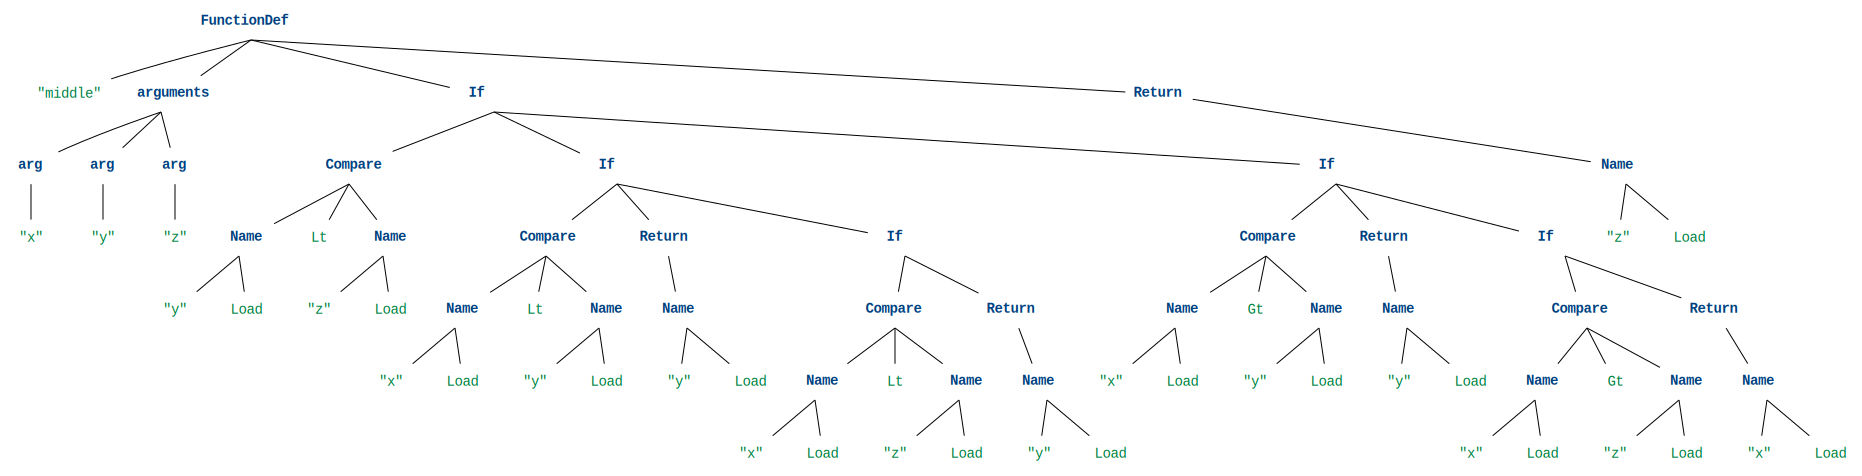

In [29]:
def middle_tree():
    return ast.parse(inspect.getsource(middle))
show_ast(middle_tree())

### Picking Statements

Let us start with a source of potential statements.

In [30]:
class StatementVisitor(NodeVisitor):
    def __init__(self):
        self.statements = []
        super().__init__()

    def add_statements(self, node, attr):
        elem = getattr(node, attr, [])
        if isinstance(elem, list):
            self.statements += elem
        else:
            self.statements.append(elem)

    def visit_Node(self, node):
        # Any node other than the ones listed below
        self.add_statements(node, 'body')
        self.add_statements(node, 'orelse')

    def visit_Module(self, node):
        # Module children are defs, classes and globals - don't add
        super().generic_visit(node)

    def visit_ClassDef(self, node):
        # Class children are defs and globals - don't add
        super().generic_visit(node)

    def generic_visit(self, node):
        self.visit_Node(node)
        super().generic_visit(node)

In [31]:
def all_statements(tree, tp=None):
    visitor = StatementVisitor()
    visitor.visit(tree)
    statements = visitor.statements
    if tp is not None:
        statements = [s for s in statements if isinstance(s, tp)]

    return statements

In [32]:
all_statements(middle_tree(), ast.Return)

We can randomly pick an element:

In [33]:
import random

In [34]:
random_node = random.choice(all_statements(middle_tree()))
astor.to_source(random_node)

'return y\n'

### Mutating Statements

In [35]:
import copy

In [36]:
class StatementMutator(NodeTransformer):
    def __init__(self, suspiciousness_func=None, 
                 statements=None, mutation_rate=0.1, log=False):

        if suspiciousness_func is None:
            suspiciousness_func = lambda lineno: 1.0
        self.suspiciousness_func = suspiciousness_func

        if statements is None:
            statements = []
        self.statements = statements

        self.mutation_rate = mutation_rate
        self.log = log

        self.mutations = 0

        super().__init__()

In [37]:
class StatementMutator(StatementMutator):
    def node_suspiciousness(self, node):
        if not hasattr(node, 'lineno'):
            return 0
        return self.suspiciousness_func(node.lineno)

In [38]:
class StatementMutator(StatementMutator):
    SKIP_LIST = {ast.Module, ast.ClassDef,
                 ast.FunctionDef, ast.AsyncFunctionDef,
                 ast.Assert}

    def should_mutate(self, node):
        if not isinstance(node, ast.stmt):
            return False
        if any(isinstance(node, cls) for cls in self.SKIP_LIST):
            return False

        suspicious_enough = (random.random() <= self.node_suspiciousness(node))
        chosen_for_mutation = (random.random() <= self.mutation_rate)
        return suspicious_enough and chosen_for_mutation

In [39]:
import re

In [40]:
RE_SPACE = re.compile(r'[ \t\n]+')

In [41]:
class StatementMutator(StatementMutator):
    def format_node(self, node):
        if node is None:
            return None
        if isinstance(node, list):
            return "; ".join(self.format_node(elem) for elem in node)

        s = RE_SPACE.sub(' ', astor.to_source(node)).strip()
        if len(s) > 20:
            s = s[:20] + "..."
        return repr(s)

    def choose_op(self):
        return random.choice([self.insert, self.swap, self.delete])

    def generic_visit(self, node):
        if not self.should_mutate(node):
            return super().generic_visit(node)

        op = self.choose_op()
        new_node = op(node)
        self.mutations += 1

        if self.log:
            print(f"{op.__name__}: {self.format_node(node)} becomes {self.format_node(new_node)}")

        return new_node

In [42]:
class StatementMutator(StatementMutator):
    def choose_statement(self):
        return copy.deepcopy(random.choice(self.statements))

In [43]:
class StatementMutator(StatementMutator):
    def swap(self, node):
        # Replace with a random node from statements
        new_node = self.choose_statement()

        if isinstance(new_node, ast.stmt):
            # The source `if P: X` is added as `if P: pass`
            if hasattr(new_node, 'body'):
                new_node.body = [ast.Pass()]
            if hasattr(new_node, 'orelse'):
                new_node.orelse = []
            if hasattr(new_node, 'finalbody'):
                new_node.finalbody = []

        ast.copy_location(new_node, node)
        return new_node

In [44]:
class StatementMutator(StatementMutator):
    def insert(self, node):
        # Insert a random node from statements
        new_node = self.choose_statement()

        if isinstance(new_node, ast.stmt) and hasattr(new_node, 'body'):
            # Inserting `if P: X` as `if P:`
            new_node.body = [node]
            if hasattr(new_node, 'orelse'):
                new_node.orelse = []
            if hasattr(new_node, 'finalbody'):
                new_node.finalbody = []
            ast.copy_location(new_node, node)
            return new_node

        # Only insert before `return`, not after it
        if isinstance(node, ast.Return):
            if isinstance(new_node, ast.Return):
                return new_node
            else:
                return [ new_node, node ]

        return [ node, new_node ]

In [45]:
class StatementMutator(StatementMutator):
    def delete(self, node):
        # Delete this node

        branches = [attr for attr in ['body', 'orelse', 'finalbody']
                    if hasattr(node, attr) and getattr(node, attr)]
        if branches:
            # Replace `if P: S` by `S`
            branch = random.choice(branches)
            new_node = getattr(node, branch)
            return new_node

        if isinstance(node, ast.stmt):
            # Avoid empty bodies; make this a `pass` statement
            new_node = ast.Pass()
            ast.copy_location(new_node, node)
            return new_node

        return None  # Just delete

In [46]:
class StatementMutator(StatementMutator):
    def visit(self, node):
        if not self.statements:
            self.statements = all_statements(node)

        return super().visit(node)

In [47]:
class StatementMutator(StatementMutator):
    def mutate(self, tree):
        tree = copy.deepcopy(tree)

        self.mutations = 0
        while self.mutations == 0:
            tree = self.visit(tree)

        ast.fix_missing_locations(tree)
        return tree

In [48]:
mutator = StatementMutator(log=True)
new_tree = mutator.mutate(middle_tree())

delete: 'if x < z: return y' becomes 'return y'
insert: 'return y' becomes 'if x > y: return y'
insert: 'return z' becomes 'if x > y: return z'


In [49]:
print_content(astor.to_source(new_tree), '.py')

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        else:
            return y
    elif x > y:
        if x > y:
            return y
    elif x > z:
        return x
    if x > y:
        return z

## Fitness

In [50]:
WEIGHT_PASSING = 0.99
WEIGHT_FAILING = 0.01

In [51]:
def middle_fitness(tree):
    original_middle = middle

    try:
        code = compile(tree, '<fitness>', 'exec')
    except ValueError:
        return 0  # Compilation error

    exec(code, globals())

    passing_passed = 0
    failing_passed = 0

    # Test how many of the passing runs pass
    for x, y, z in MIDDLE_PASSING_TESTCASES:
        try:
            middle_test(x, y, z)
            passing_passed += 1
        except AssertionError:
            pass

    passing_ratio = passing_passed / len(MIDDLE_PASSING_TESTCASES)

    # Test how many of the failing runs pass
    for x, y, z in MIDDLE_FAILING_TESTCASES:
        try:
            middle_test(x, y, z)
            failing_passed += 1
        except AssertionError:
            pass

    failing_ratio = failing_passed / len(MIDDLE_FAILING_TESTCASES)

    fitness = (WEIGHT_PASSING * passing_ratio +
               WEIGHT_FAILING * failing_ratio)

    globals()['middle'] = original_middle
    return fitness

In [52]:
middle_fitness(middle_tree())

0.99

In [53]:
middle_fitness(ast.parse("def middle(x, y, z): return z"))

0.495

In [54]:
from StatisticalDebugger import middle_fixed

In [55]:
middle_fixed_source = \
    inspect.getsource(middle_fixed).replace('middle_fixed', 'middle').strip()

In [56]:
middle_fitness(ast.parse(middle_fixed_source))

1.0

## Population

In [57]:
MIDDLE_POPSIZE = 20
mutator = StatementMutator()

In [58]:
MIDDLE_POPULATION = [middle_tree()] + \
    [mutator.mutate(middle_tree()) for i in range(MIDDLE_POPSIZE - 1)]

In [59]:
MIDDLE_POPULATION.sort(key=middle_fitness, reverse=True)

Highest fitness:

In [60]:
print(astor.to_source(MIDDLE_POPULATION[0]), 
      middle_fitness(MIDDLE_POPULATION[0]))

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z
 1.0


Lowest fitness:

In [61]:
print(astor.to_source(MIDDLE_POPULATION[-1]), 
      middle_fitness(MIDDLE_POPULATION[-1]))

def middle(x, y, z):
    if x < y:
        return y
    elif x < z:
        return y
    return z
 0.3564


## Evolution

In [62]:
def evolve_middle():
    global MIDDLE_POPULATION

    statements = all_statements(middle_tree())
    mutator = StatementMutator(statements=statements)

    n = len(MIDDLE_POPULATION)

    MIDDLE_POPULATION.sort(key=middle_fitness, reverse=True)
    MIDDLE_POPULATION = MIDDLE_POPULATION[:n // 2]

    offspring = [mutator.mutate(tree) for tree in MIDDLE_POPULATION]

    MIDDLE_POPULATION += offspring

In [63]:
evolve_middle()

In [64]:
tree = MIDDLE_POPULATION[0]
print(astor.to_source(tree), middle_fitness(tree))

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z
 1.0


In [65]:
evolve_middle()

In [66]:
evolve_middle()

In [67]:
evolve_middle()

In [68]:
evolve_middle()

In [69]:
tree = MIDDLE_POPULATION[0]
print(astor.to_source(tree), middle_fitness(tree))

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z
 1.0


In [70]:
for i in range(5):
    evolve_middle()
    best_tree = MIDDLE_POPULATION[0]
    print(middle_fitness(best_tree), end=" ")

1.0 1.0 1.0 1.0 1.0 

In [71]:
print_content(astor.to_source(best_tree), '.py')

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z

## Simplifying

### Textual Reduction

We could use `DeltaDebugger` on code to minimize the whole thing.

In [72]:
from DeltaDebugger import DeltaDebugger

In [73]:
middle_lines = astor.to_source(best_tree).split('\n')

In [74]:
def test_middle_lines(lines):
    source = "\n".join(lines)
    tree = ast.parse(source)
    assert middle_fitness(tree) < 1.0  # "Fail" only while fitness is 1.0

In [75]:
with DeltaDebugger() as dd:
    test_middle_lines(middle_lines)

In [76]:
reduced_source = "\n".join(dd.min_args()['lines'])
repaired_source = astor.to_source(ast.parse(reduced_source))  # normalize
print_content(repaired_source, '.py')

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z

We can present the difference to the original as a patch:

In [77]:
print(middle_source)

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    else:
        if x > y:
            return y
        elif x > z:
            return x
    return z



In [78]:
original_source = astor.to_source(ast.parse(middle_source))  # normalize

In [79]:
print(original_source)

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    elif x > y:
        return y
    elif x > z:
        return x
    return z



In [80]:
from ChangeDebugger import diff

In [81]:
import urllib

In [82]:
def print_patch(p):
    print_content(urllib.parse.unquote(str(p)), '.py')

In [83]:
original = original_source
repair = repaired_source

In [84]:
for patch in diff(original, repair):
    print_patch(patch)

@@ -87,37 +87,37 @@
  x < z:

-            return y

+            return x

     elif

## Crossover

Pick two ASTs. Pick two functions. Do a crossover on any body sequence.

In [85]:
def p1():
    def inner():
        print(a)
        print(b)
        print(c)

    a = 1
    b = 2
    c = 3

In [86]:
def p2():
    def inner():
        print(x)
        print(y)
        print(z)

    x = 1
    y = 2
    z = 3

In [87]:
class BodyCrossover:
    def __init__(self, log=False):
        self.log = log

    def cross_bodies(self, body_1, body_2):
        """Crossover the statement lists `body_1` x `body_2`.
        Return new lists.
        """

        assert isinstance(body_1, list)
        assert isinstance(body_2, list)

        split_1 = len(body_1) // 2
        split_2 = len(body_2) // 2
        return body_1[:split_1] + body_2[split_2:], body_2[:split_2] + body_1[split_1:]

In [88]:
tree_p1 = ast.parse(inspect.getsource(p1))
tree_p2 = ast.parse(inspect.getsource(p2))

In [89]:
body_p1 = tree_p1.body[0].body
body_p2 = tree_p2.body[0].body
body_p1

In [90]:
crosser = BodyCrossover()
tree_p1.body[0].body, tree_p2.body[0].body = crosser.cross_bodies(body_p1, body_p2)

In [91]:
print_content(astor.to_source(tree_p1), '.py')

def p1():

    def inner():
        print(a)
        print(b)
        print(c)
    a = 1
    y = 2
    z = 3

In [92]:
print_content(astor.to_source(tree_p2), '.py')

def p2():

    def inner():
        print(x)
        print(y)
        print(z)
    x = 1
    b = 2
    c = 3

In [93]:
class BodyCrossover(BodyCrossover):
    # In modules and class defs, the ordering of elements does not matter (much)
    SKIP_LIST = {ast.Module, ast.ClassDef}

    def can_cross(self, tree, body_attr='body'):
        if any(isinstance(tree, cls) for cls in self.SKIP_LIST):
            return False

        body = getattr(tree, body_attr, [])
        return body and len(body) >= 2

In [94]:
class BodyCrossover(BodyCrossover):
    def crossover_attr(self, t1, t2, body_attr):
        """Crossover the bodies `body_attr` of two trees `t1` and `t2`.
        Return True if successful."""
        assert isinstance(t1, ast.AST)
        assert isinstance(t2, ast.AST)
        assert isinstance(body_attr, str)

        if not getattr(t1, body_attr, None) or not getattr(t2, body_attr, None):
            return False

        body_1 = getattr(t1, body_attr)
        body_2 = getattr(t2, body_attr)

        # print(f"t1.{body_attr} = {body_1}")
        # print(f"t2.{body_attr} = {body_2}")

        # If both trees have the attribute, we can cross their bodies
        if self.can_cross(t1, body_attr) and self.can_cross(t2, body_attr):
            if self.log:
                print(f"Crossing {t1}.{body_attr} and {t2}.{body_attr}")

            new_body_1, new_body_2 = self.cross_bodies(body_1, body_2)
            setattr(t1, body_attr, new_body_1)
            setattr(t2, body_attr, new_body_2)
            return True

        # Strategy 1: Find matches in class/function of same name
        for child_1 in body_1:
            if hasattr(child_1, 'name'):
                for child_2 in body_2:
                    if (hasattr(child_2, 'name') and
                           child_1.name == child_2.name):
                        if self.crossover(child_1, child_2):
                            return True

        # Strategy 2: Find matches anywhere
        for child_1 in random.sample(body_1, len(body_1)):
            for child_2 in random.sample(body_2, len(body_2)):
                if self.crossover(child_1, child_2):
                    return True

        return False

In [95]:
class BodyCrossover(BodyCrossover):
    def crossover_branches(self, t1, t2):
        """Special case:
        `t1` = `if P: S1 else: S2` x `t2` = `if P': S1' else: S2'`
        becomes
        `t1` = `if P: S2' else: S1'` and `t2` = `if P': S2 else: S1`
        Returns True if successful.
        """
        assert isinstance(t1, ast.AST)
        assert isinstance(t2, ast.AST)
        
        if (hasattr(t1, 'body') and hasattr(t1, 'orelse') and
            hasattr(t2, 'body') and hasattr(t2, 'orelse')):
            t1.body, t1.orelse, t2.body, t2.orelse = \
                t2.orelse, t2.body, t2.orelse, t1.body
            return True

        return False

In [96]:
class CrossoverError(ValueError):
    pass

In [97]:
class BodyCrossover(BodyCrossover):
    def crossover(self, t1, t2):
        """Do a crossover of ASTs `t1` and `t2`.
        Raises `CrossoverError` if no crossover is found."""
        assert isinstance(t1, ast.AST)
        assert isinstance(t2, ast.AST)

        if self.crossover_branches(t1, t2):
            return t1, t2

        for body_attr in ['body', 'orelse', 'finalbody']:
            if self.crossover_attr(t1, t2, body_attr):
                return t1, t2

        raise CrossoverError("No crossover found")

In [98]:
def p1():
    if True:
        print(1)
        print(2)
        print(3)

In [99]:
def p2():
    if True:
        print(a)
        print(b)
    if False:
        print(c)
        print(d)

In [100]:
crossover = BodyCrossover(log=True)
tree_p1 = ast.parse(inspect.getsource(p1))
tree_p2 = ast.parse(inspect.getsource(p2))
crossover.crossover(tree_p1, tree_p2)

(<_ast.Module at 0x7f8153b06ef0>, <_ast.Module at 0x7f8153848828>)

In [101]:
print_content(astor.to_source(tree_p1), '.py')

def p1():
    if True:
    else:
        print(c)
        print(d)

In [102]:
print_content(astor.to_source(tree_p2), '.py')

def p2():
    if True:
        print(a)
        print(b)
    if False:
    else:
        print(1)
        print(2)
        print(3)

## A Repairer Class

In [103]:
class RobustCoverageCollector(CoverageCollector):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.exception_type = None

    def __exit__(self, tp, value, traceback):
        """Called at end of `with` block. Turn tracing off."""
        super().__exit__(tp, value, traceback)
        self.exception_type = tp
        return True  # ignore exception

In [104]:
class Repairer(OchiaiDebugger):
    def __init__(self, *args, **kwargs):
        return super().__init__(RobustCoverageCollector, *args, **kwargs)

In [105]:
class FailureNotReproducedError(ValueError):
    pass

In [106]:
class Repairer(Repairer):
    def run_test_set(self, test_set, validate=False):
        passed = 0
        collectors = self.collectors[test_set]
        function = globals()[self.function().__name__]  # may be redefined

        for c in collectors:
            if self.log > 2:
                print(f"Testing {c.id()}...", end="")

            try:
                function(**c.args())
            except Exception as err:
                if self.log > 2:
                    print(f"failed ({err.__class__.__name__})")

                if validate and test_set == self.PASS:
                    raise err(
                        f"{c.id()} should have passed, but failed")
                continue

            passed += 1
            if self.log > 2:
                print("passed")

            if validate and test_set == self.FAIL:
                raise FailureNotReproducedError(
                    f"{c.id()} should have failed, but passed")

        return passed

In [107]:
class Repairer(Repairer):
    def weight(self, test_set):
        return {
            self.PASS: WEIGHT_PASSING,
            self.FAIL: WEIGHT_FAILING
        }[test_set]

    def run_tests(self, validate=False):
        # Run tests
        fitness = 0

        for test_set in [self.PASS, self.FAIL]:
            passed = self.run_test_set(test_set, validate=validate)
            ratio = passed / len(self.collectors[test_set])
            fitness += self.weight(test_set) * ratio

        return fitness

In [108]:
class DefinitionVisitor(NodeVisitor):
    def __init__(self):
        self.definitions = []

    def add_definition(self, node):
        self.definitions.append(node.name)

    def visit_FunctionDef(self, node):
        self.add_definition(node)

    def visit_AsyncFunctionDef(self, node):
        self.add_definition(node)

    def visit_Class(self, node):
        self.add_definition(node)

In [109]:
class Repairer(Repairer):
    def toplevel_defs(self, tree):
        visitor = DefinitionVisitor()
        visitor.visit(tree)
        return visitor.definitions

In [110]:
class Repairer(Repairer):
    def fitness(self, tree):
        # Save defs
        original_defs = {}
        for name in self.toplevel_defs(tree):
            original_defs[name] = globals()[name]

        if self.log > 1:
            print("Repair candidate:")
            print_content(astor.to_source(tree), '.py')
            print()

        # Create new definition
        try:
            code = compile(tree, '<Repairer>', 'exec')
        except ValueError:  # Compilation error
            if self.log > 1:
                print(f"Fitness = 0 (compilation error)")

            fitness = 0
            return fitness

        exec(code, globals())

        fitness = self.run_tests(validate=False)

        for name in original_defs:
            globals()[name] = original_defs[name]

        if self.log > 1:
            print(f"Fitness = {fitness}")

        return fitness

In [111]:
class Repairer(Repairer):
    def validate(self):
        fitness = self.run_tests(validate=True)
        assert fitness == self.weight(self.PASS)

In [112]:
class Repairer(Repairer):
    def getsource(self, item):
        if isinstance(item, str):
            item = globals()[item]
        return inspect.getsource(item)

In [113]:
import math

In [114]:
class Repairer(Repairer):
    def default_functions(self):
        def is_test(name):
            return name.startswith('test') or name.endswith('test')

        return [func for func in self.covered_functions()
                if not is_test(func)]

    def log_tree(self, description, tree):
        if self.log:
            print(description)
            print_content(astor.to_source(tree), '.py')
            print()
            print()

    def repair(self, targets=None, sources=None, population_size=100,
               iterations=100, 
               mutator_cls=StatementMutator, mutator=None, 
               crossover_cls=BodyCrossover, crossover=None):
        """Repair the function test runs collected from.
        `targets`: a list of function/module names to be repaired.
        (default: covered functions)
        `sources`: a list of function/module names to take repairs from.
        (default: `targets`)
        """
        if targets is None:
            targets = self.default_functions()
        if not targets:
            raise ValueError("No targets to repair")

        if sources is None:
            sources = self.default_functions()
        if not sources:
            raise ValueError("No sources to take repairs from")

        if self.function() is None:
            raise ValueError("Multiple entry points observed")

        all_targets = "".join(self.getsource(src) for src in targets)
        all_sources = "".join(self.getsource(src) for src in sources)

        target_tree = ast.parse(all_targets)
        source_tree = ast.parse(all_sources)

        self.log_tree("Target code to be repaired:", target_tree)
        if all_targets != all_sources:
            self.log_tree("Source code to take repairs from:", source_tree)

        self.validate()

        if mutator is None:
            statements = all_statements(source_tree)
            mutator = mutator_cls(statements=statements)
        if crossover is None:
            crossover = crossover_cls()

        population = [target_tree] + \
            [mutator.mutate(copy.deepcopy(target_tree))
                for i in range(population_size)]

        if self.log:
            print("Evolving population:", end="")

        for i in range(iterations):
            population = self.evolve(population, mutator, crossover)

            best_tree = population[0]
            fitness = self.fitness(best_tree)
            if self.log:
                print(f" {fitness:.3}", end="")
            if math.isclose(fitness, 1.0):
                break

        if self.log:
            print()
            print()

        self.log_tree(f"Best code (fitness = {fitness}):", best_tree)

        best_tree = self.reduce(best_tree)
        fitness = self.fitness(best_tree)

        self.log_tree(f"Reduced code (fitness = {fitness}):", best_tree)

        return best_tree, fitness

In [115]:
class Repairer(Repairer):
    def evolve(self, population, mutator, crossover):
        n = len(population)

        population.sort(key=self.fitness, reverse=True)
        population = population[:n // 2]

        offspring = [mutator.mutate(tree) for tree in population]
        population += offspring

        return population

In [116]:
class Repairer(Repairer):
    def fitness_key(self, tree):
        tree_size = len([node for node in ast.walk(tree)])
        return (self.fitness(tree), -tree_size)

In [117]:
class Repairer(Repairer):
    def evolve(self, population, mutator, crossover):
        n = len(population)

        # Keep the fitter half of the population
        population.sort(key=self.fitness_key, reverse=True)
        population = population[:n // 2]

        # Create offspring as crossover of parents
        offspring = []
        while len(offspring) < n // 2:
            parent_1 = copy.deepcopy(random.choice(population))
            parent_2 = copy.deepcopy(random.choice(population))
            try:
                crossover.crossover(parent_1, parent_2)
                offspring += [parent_1, parent_2]
            except CrossoverError:
                # Try different parents
                pass

        # Mutate offspring
        offspring = [mutator.mutate(tree) for tree in offspring]
        population += offspring

        return population

In [118]:
class Repairer(Repairer):
    def test_reduce(self, lines, original_fitness):
        source = "\n".join(lines)
        tree = ast.parse(source)
        assert self.fitness(tree) < original_fitness

    def reduce(self, tree):
        original_fitness = self.fitness(tree)
        source_lines = astor.to_source(tree).split('\n')

        with DeltaDebugger() as dd:
            self.test_reduce(source_lines, original_fitness)

        reduced_source = "\n".join(dd.min_args()['lines'])
        return ast.parse(reduced_source)

In [119]:
repairer = Repairer(log=1)

In [120]:
for x, y, z in MIDDLE_PASSING_TESTCASES:
    with repairer.collect_pass():
        m = middle_test(x, y, z)

In [121]:
for x, y, z in MIDDLE_FAILING_TESTCASES:
    with repairer.collect_fail():
        m = middle_test(x, y, z)

In [122]:
best_tree, fitness = repairer.repair()

Target code to be repaired:
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    elif x > y:
        return y
    elif x > z:
        return x
    return z

Evolving population: 0.99 0.99 0.99 0.99 1.0

Best code (fitness = 1.0):
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            pass
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z

Reduced code (fitness = 1.0):
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z



In [123]:
print_content(astor.to_source(best_tree), '.py')

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z

In [124]:
fitness

1.0

## More Examples

### Removing HTML Markup

In [125]:
def remove_html_markup(s):
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

In [126]:
def remove_html_markup_tree():
    return ast.parse(inspect.getsource(remove_html_markup))

In [127]:
def remove_html_markup_test(html, plain):
    outcome = remove_html_markup(html)
    assert outcome == plain, \
        f"Got {repr(outcome)}, expected {repr(plain)}"

In [128]:
globals()['remove_html_markup_test']

<function __main__.remove_html_markup_test(html, plain)>

In [129]:
remove_html_markup_test('<foo>bar</foo>', 'bar')

In [130]:
from ExpectError import ExpectError

In [131]:
with ExpectError():
    remove_html_markup_test('<foo>"bar"</foo>', '"bar"')

Traceback (most recent call last):
  File "<ipython-input-131-ab8b69125260>", line 2, in <module>
    remove_html_markup_test('<foo>"bar"</foo>', '"bar"')
  File "<ipython-input-127-a492611f8c18>", line 4, in remove_html_markup_test
    f"Got {repr(outcome)}, expected {repr(plain)}"
AssertionError: Got 'bar', expected '"bar"' (expected)


In [132]:
def random_string(length=5, start=ord(' '), end=ord('~')):
    return "".join(chr(random.randrange(start, end + 1)) for i in range(length))

In [133]:
random_string()

'uQ+:L'

In [134]:
def random_id(length=2):
    return random_string(start=ord('a'), end=ord('z'))

In [135]:
random_id()

'mwpeh'

In [136]:
def random_plain():
    return random_string().replace('<', '').replace('>', '')

In [137]:
def random_string_noquotes():
    return random_string().replace('"', '').replace("'", '')

In [138]:
def random_html(depth=0):
    prefix = random_plain()
    tag = random_id()

    if depth > 0:
        html, plain = random_html(depth - 1)
    else:
        html = plain = random_plain()

    attr = random_id()
    value = '"' + random_string_noquotes() + '"'
    postfix = random_plain()

    return f'{prefix}<{tag} {attr}={value}>{html}</{tag}>{postfix}', \
        prefix + plain + postfix

In [139]:
random_html()

(',1j=U<xhyld atczk=")Vl!w">PF DE</xhyld>tor.{', ',1j=UPF DEtor.{')

In [140]:
def remove_html_testcase(expected=True):
    while True:
        html, plain = random_html()
        outcome = (remove_html_markup(html) == plain)
        if outcome == expected:
            return html, plain

In [141]:
REMOVE_HTML_PASSING_TESTCASES = \
    [remove_html_testcase(True) for i in range(100)]
REMOVE_HTML_FAILING_TESTCASES = \
    [remove_html_testcase(False) for i in range(100)]

In [142]:
REMOVE_HTML_PASSING_TESTCASES[0]

('9S7d}<nduyb uupfx="; !-4">Yly|q</nduyb>eSoZp', '9S7d}Yly|qeSoZp')

In [143]:
REMOVE_HTML_FAILING_TESTCASES[0]

('S:JK"<mneae gczxb="s?[Az">V~Jw*</mneae>`t]p', 'S:JK"V~Jw*`t]p')

In [144]:
for html, plain in REMOVE_HTML_FAILING_TESTCASES:
    try:
        remove_html_markup_test(html, plain)
        assert False
    except:
        pass

In [145]:
for html, plain in REMOVE_HTML_PASSING_TESTCASES:
    remove_html_markup_test(html, plain)

In [146]:
repairer = Repairer(log=1)

In [147]:
for html, plain in REMOVE_HTML_PASSING_TESTCASES:
    with repairer.collect_pass():
        remove_html_markup_test(html, plain)

In [148]:
for html, plain in REMOVE_HTML_FAILING_TESTCASES:
    with repairer.collect_fail():
        remove_html_markup_test(html, plain)

In [149]:
from IPython.display import HTML

In [150]:
with ExpectError():
    repairer.code()  # FIXME

Traceback (most recent call last):
  File "<ipython-input-150-2cfddbf9b356>", line 2, in <module>
    repairer.code()  # FIXME
  File "StatisticalDebugger.ipynb", line 384, in code
    function = globals()[function]
KeyError: 'remove_html_markup_test' (expected)


In [151]:
HTML(repairer.code(function=remove_html_markup, color=True))

In [152]:
best_tree, fitness = repairer.repair(population_size=100)

Target code to be repaired:
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    return out

Evolving population: 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99

Best code (fitness = 0.99):
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
  

## Mutate Conditions

In [153]:
class ConditionVisitor(NodeVisitor):
    def __init__(self):
        self.conditions = []
        self.conditions_seen = set()
        super().__init__()

    def add_conditions(self, node, attr):
        elems = getattr(node, attr, [])
        if not isinstance(elems, list):
            elems = [elems]

        for elem in elems:
            elem_str = astor.to_source(elem)
            if elem_str not in self.conditions_seen:
                self.conditions.append(elem)
                self.conditions_seen.add(elem_str)

    def visit_BoolOp(self, node):
        self.add_conditions(node, 'values')
        super().generic_visit(node)

    def visit_UnaryOp(self, node):
        if isinstance(node.op, ast.Not):
            self.add_conditions(node, 'operand')
        super().generic_visit(node)

    def generic_visit(self, node):
        if hasattr(node, 'test'):
            self.add_conditions(node, 'test')
        super().generic_visit(node)

In [154]:
def all_conditions(trees, tp=None):
    if not isinstance(trees, list):
        assert isinstance(trees, ast.AST)
        trees = [trees]

    visitor = ConditionVisitor()
    for tree in trees:
        visitor.visit(tree)
    conditions = visitor.conditions
    if tp is not None:
        conditions = [c for c in conditions if isinstance(c, tp)]

    return conditions

In [155]:
[astor.to_source(cond).strip() for cond in all_conditions(remove_html_markup_tree())]

["(c == '<' and not quote)",
 "c == '<'",
 'not quote',
 'quote',
 "(c == '>' and not quote)",
 "c == '>'",
 '(c == \'"\' or c == "\'" and tag)',
 'c == \'"\'',
 'c == "\'" and tag',
 'c == "\'"',
 'tag',
 '(not tag)']

In [156]:
class ConditionMutator(StatementMutator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conditions = all_conditions(self.statements)
        if self.log:
            print("Found conditions",
                  [astor.to_source(cond).strip() for cond in self.conditions])

    def choose_condition(self):
        return copy.deepcopy(random.choice(self.conditions))

In [157]:
class ConditionMutator(ConditionMutator):
    def choose_bool_op(self):
        return random.choice(['set', 'not', 'and', 'or'])

    def swap(self, node):
        if not hasattr(node, 'test'):
            return super().swap(node)

        c1 = self.choose_condition()
        c2 = self.choose_condition()
        new_test = None

        choice = self.choose_bool_op()

        if choice == 'set':
            new_test = c1
        elif choice == 'not':
            new_test = ast.UnaryOp(op=ast.Not(), operand=c1)
        elif choice == 'and':
            new_test = ast.BoolOp(op=ast.And(), values=[c1, c2])
        elif choice == 'or':
            new_test = ast.BoolOp(op=ast.Or(), values=[c1, c2])
        else:
            raise ValueError("Unknown boolean operand")

        if new_test:
            ast.copy_location(new_test, node)
            node.test = new_test

        return node

In [158]:
mutator = ConditionMutator(statements=all_statements(remove_html_markup_tree()), log=True)

Found conditions ["(c == '<' and not quote)", "c == '<'", 'not quote', 'quote', "(c == '>' and not quote)", "c == '>'", '(c == \'"\' or c == "\'" and tag)', 'c == \'"\'', 'c == "\'" and tag', 'c == "\'"', 'tag', '(not tag)']


In [159]:
new_tree = mutator.mutate(remove_html_markup_tree())

delete: "out = ''" becomes 'pass'
insert: 'for c in s: if c == ...' becomes "if c == '<' and not ..."


In [160]:
repairer = Repairer(log=True)

In [161]:
for html, plain in REMOVE_HTML_PASSING_TESTCASES:
    with repairer.collect_pass():
        remove_html_markup_test(html, plain)

In [162]:
for html, plain in REMOVE_HTML_FAILING_TESTCASES:
    with repairer.collect_fail():
        remove_html_markup_test(html, plain)

In [163]:
repairer.repair(mutator_cls=ConditionMutator)

Target code to be repaired:
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    return out

Evolving population: 1.0

Best code (fitness = 1.0):
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
            quote = False
        elif tag and c == '"':
            quote = not quote
        elif not tag:
            out = out + c
    return out

Reduced code (fitness = 1.0):
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote

(<_ast.Module at 0x7f8153d81a90>, 1.0)

## Synopsis

We can repair things!

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

To learn more about automated program repair, see [program-repair.org](http://program-repair.org), the community page dedicated to research in program repair.  Also check out the [GenProg project page](https://squareslab.github.io/genprog-code/).

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: _Title_

_Text of the exercise_

In [164]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [165]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2: _Title_

_Text of the exercise_

**Solution.** _Solution for the exercise_

In [166]:
class PrunePassTransformer(NodeTransformer):
    def prune_pass(self, body):
        if not body:
            return body

        # Get rid of `pass` statements
        new_body = list(filter(lambda stmt: not isinstance(stmt, ast.Pass), body))
        if len(new_body) == 0:
            # Oops – we need at least one `pass`
            new_node = ast.Pass()
            ast.copy_location(new_node, body[0])
            new_body = [new_node]

        return new_body
    
    def visit_Node(self, node):
        if hasattr(node, 'body'):
            node.body = self.prune_pass(node.body)
        if hasattr(node, 'orelse'):
            node.orelse = self.prune_pass(node.orelse)
        return node

    def generic_visit(self, node):
        super().generic_visit(node)
        return self.visit_Node(node)

In [167]:
prune_passes = PrunePassTransformer()
prune_passes.visit(best_tree)
print_content(astor.to_source(best_tree), '.py')

def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    return out

In [168]:
class PruneReturnTransformer(NodeTransformer):
    def ends_in_return(self, body):
        return len(body) > 0 and isinstance(body[-1], ast.Return)

    def prune_returns(self, body):
        if body is None:
            return None

        # Get rid of statements after `return`
        for i, stmt in enumerate(body):
            if isinstance(stmt, ast.Return):
                body = body[:i + 1]
                break
            if isinstance(stmt, ast.If):
                body_returns = self.ends_in_return(stmt.body)
                orelse_returns = self.ends_in_return(stmt.orelse)
                if body_returns and orelse_returns:
                    body = body[:i + 1]
                    break

        return body

    def visit_Node(self, node):
        if hasattr(node, 'body'):
            node.body = self.prune_returns(node.body)
        if hasattr(node, 'orelse'):
            node.orelse = self.prune_returns(node.orelse)
        return node

    def generic_visit(self, node):
        super().generic_visit(node)
        return self.visit_Node(node)

In [169]:
prune_returns = PruneReturnTransformer()
prune_returns.visit(best_tree)
print_content(astor.to_source(best_tree), '.py')

def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    return out